In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
from torch.utils.data import DataLoader  
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter

In [6]:
class Discriminator(nn.Module):
  
  def __init__(self, img_dim):
    super().__init__()
    self.disc = nn.Sequential(
        nn.Linear(img_dim , 128),
        nn.LeakyReLU(0.1) , # Slope of 0.1 , leaky relu performs better in GANs
        nn.Linear(128 , 1),
        nn.Sigmoid(),
    )
  
  def forward(self,x):
    return self.disc(x)

class Generator(nn.Module):
  def __init__(self , z_dim , img_dim):
    super().__init__()
    self.gen = nn.Sequential(
      nn.Linear(z_dim , 256),
        nn.LeakyReLU(0.1) , # Slope of 0.1 , leaky relu performs better in GANs
        nn.Linear(256 , img_dim),
        nn.Tanh(),
    )
  
  def forward(self,x):
    return self.gen(x)


# New section

In [8]:
# Goes under config.py 


# Hyperparamas
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device : " , device)
lr = 3e-4
z_dim = 64 # 128 , 256 
img_dim = 28*28*1 # 784
batch_size = 32
num_epochs = 10

# defining variables
disc = Discriminator(img_dim).to(device)
gen = Generator(z_dim , img_dim).to(device)
fixed_noise = torch.randn((batch_size,z_dim)).to(device)

# transforms 
import torchvision.transforms as transforms
transforms = transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize((0.5,),(0.5,))
      ]
)

# datasets 
dataset = datasets.MNIST(root = "dataset/" , transform = transforms , download = True)
loader = DataLoader(dataset , batch_size = batch_size , shuffle = True) 

# optimizers 
optim_disc = optim.Adam(disc.parameters() , lr = lr)
optim_gen = optim.Adam(gen.parameters() , lr = lr)

# Loss Fn
criterion = nn.BCELoss()

# Tensorboard
writer_fake = SummaryWriter(f"runs/GAN_MNIST/fake")
writer_real = SummaryWriter(f"runs/GAN_MNIST/real")
step = 0 


Device :  cuda


In [9]:

def plot_images(t):
  # Ploting some of the datapoints in the dataset
  import matplotlib.pyplot as plt
  from IPython import display
  # sample_img , sample_lbl = temp_train_dataset[3]
  figure = plt.figure(figsize=(8, 8))
  cols, rows = 6, 6
  figure.add_subplot(rows, cols, 1)
  for i in range(data.shape[0]):
      img = t[i].cpu().numpy()
      figure.add_subplot(rows, cols, i+1)
      plt.axis("off")
      plt.imshow(img.squeeze(), cmap="gray")
      display.display(plt.gcf())
      display.clear_output(wait=True)
      

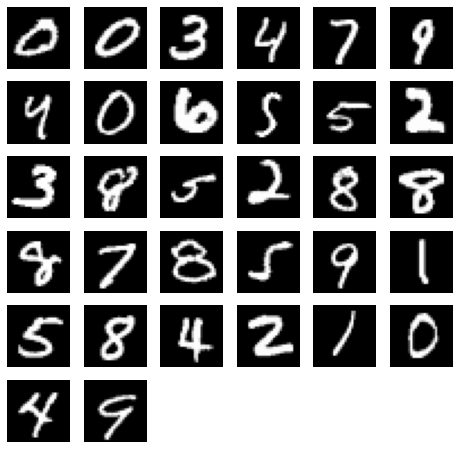

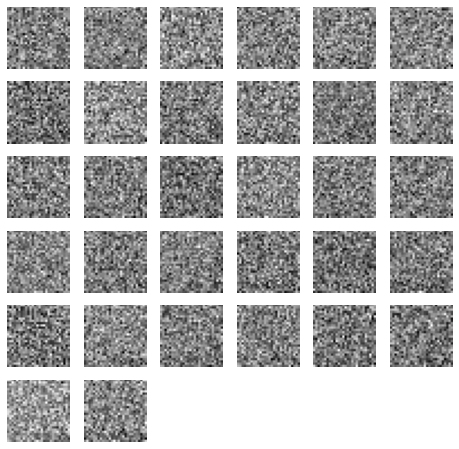

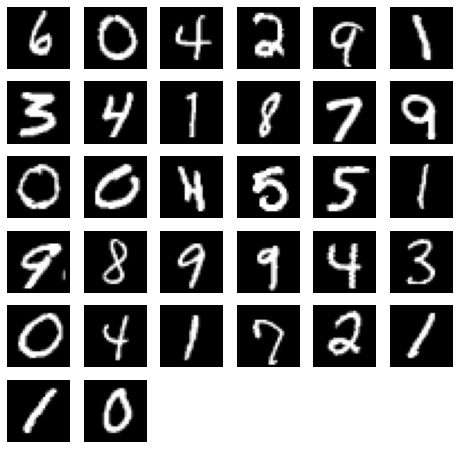

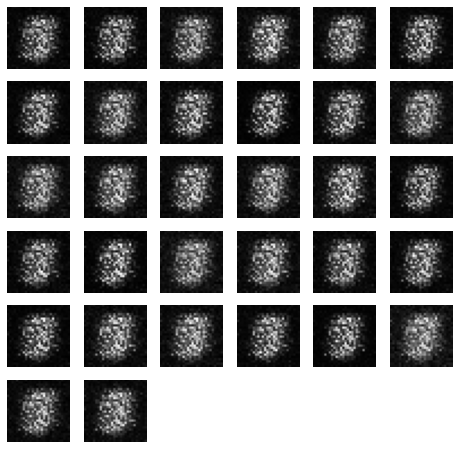

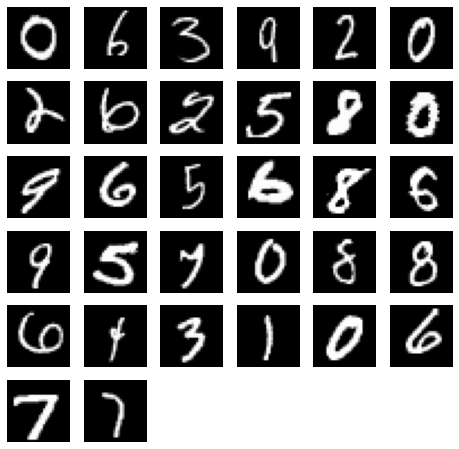

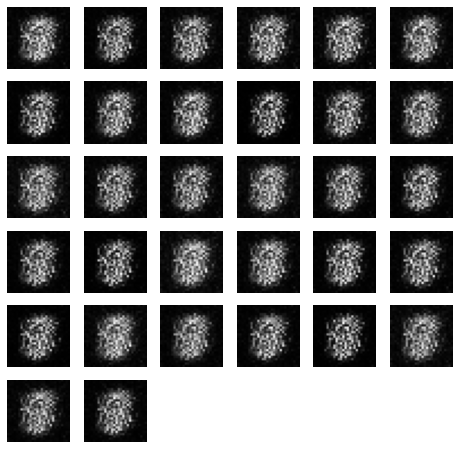

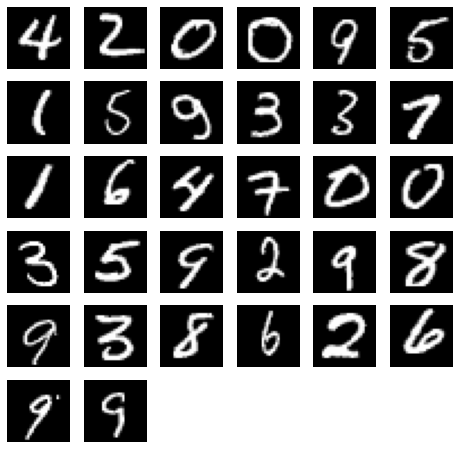

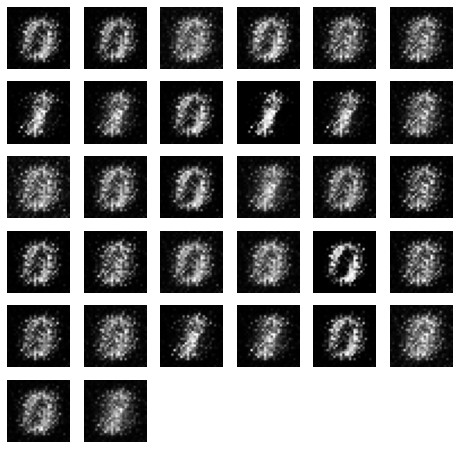

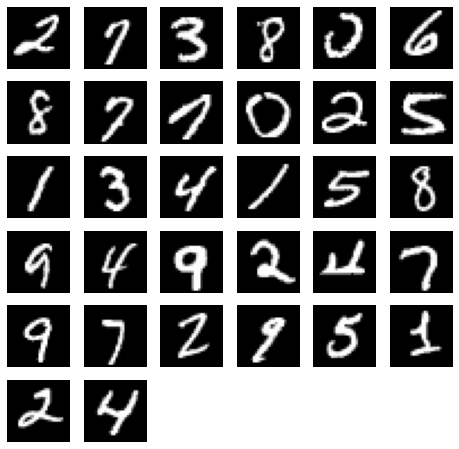

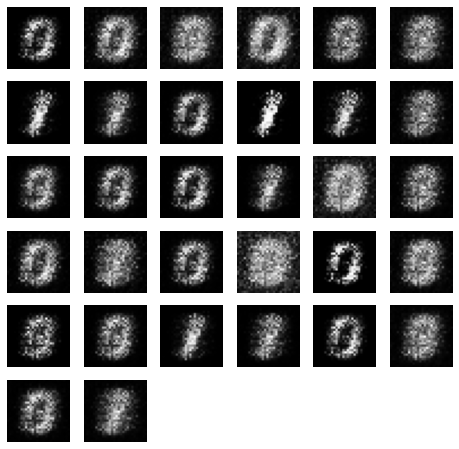

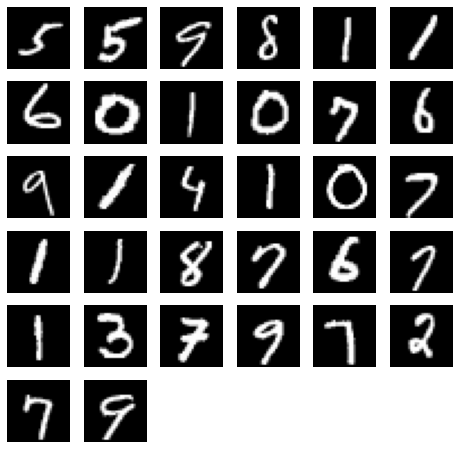

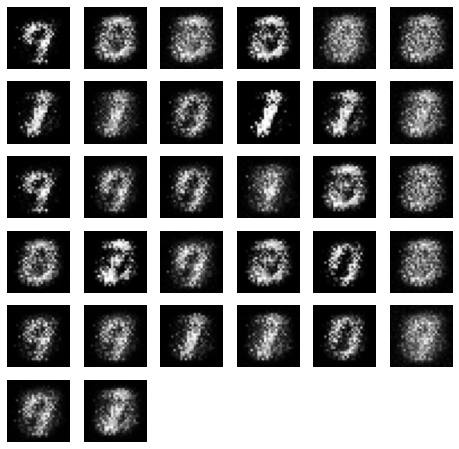

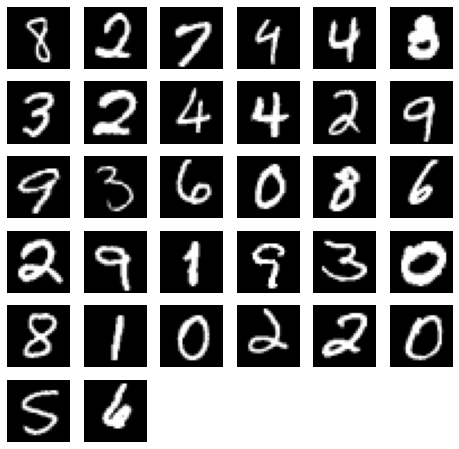

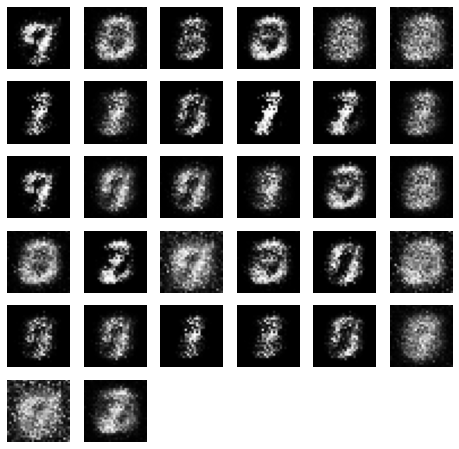

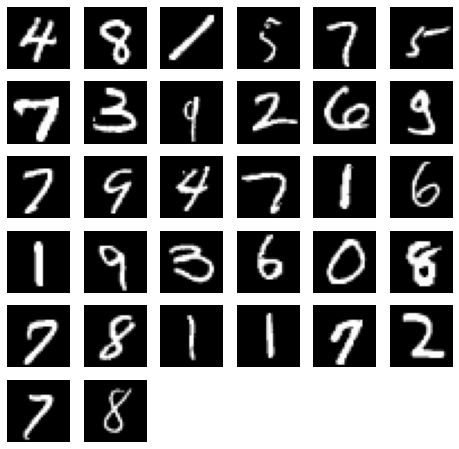

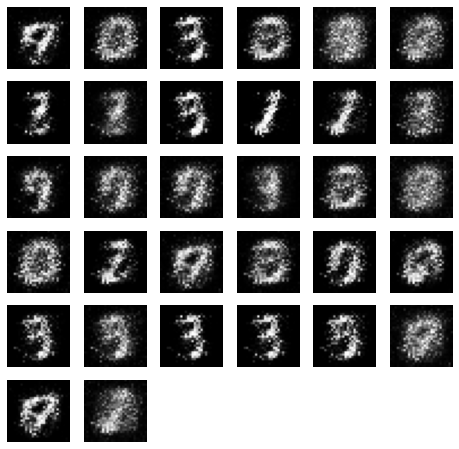

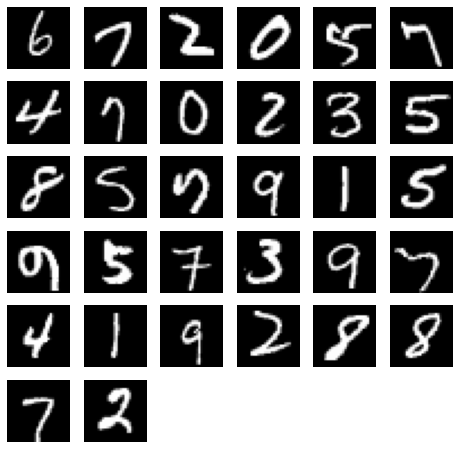

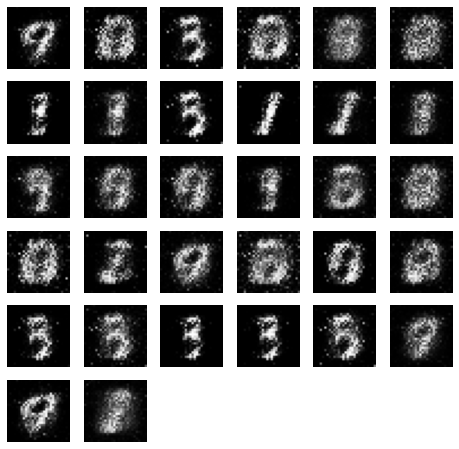

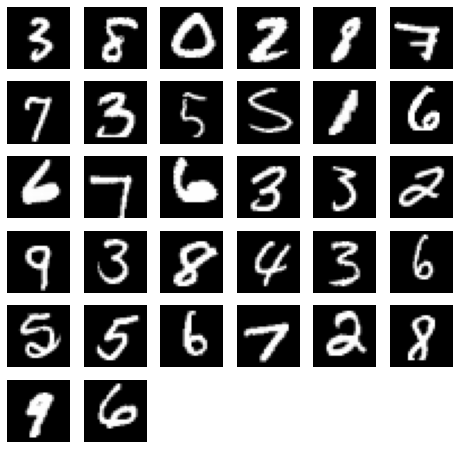

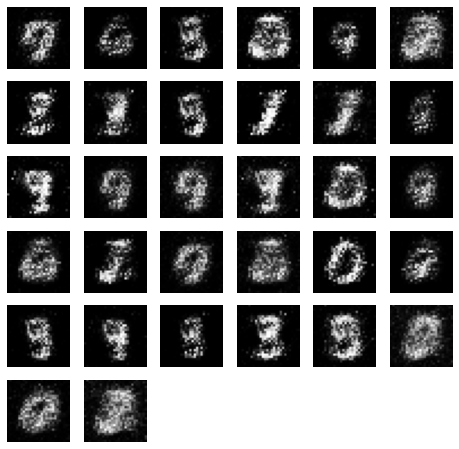

In [11]:
for epoch in range(num_epochs):
  for batch_idx , (real , _) in enumerate(loader):
    
    real = real.view(-1,784).to(device) # resizing images
    batch_size = real.shape[0]

    # Discriminator training : max : log(D(real)) + log(1-D(G(z)))
    
    noise = torch.randn(batch_size,z_dim).to(device)
    fake = gen(noise)
    disc_real = disc(real).view(-1)
    disc_fake = disc(fake).view(-1)

    lossD_real = criterion(disc_real , torch.ones_like(disc_real))
    lossD_fake = criterion(disc_fake , torch.zeros_like(disc_fake))

    lossD = (lossD_real + lossD_fake)/2

    disc.zero_grad()
    lossD.backward(retain_graph=True) # clears the gradients from cache
    optim_disc.step()

    # Generator training : min log(1-D(G(z))) -> max log(D(G(z)))
    
    output = disc(fake).view(-1)
    lossG = criterion(output , torch.ones_like(output))
    gen.zero_grad()
    lossG.backward() # don't need to retain since it's not needed anymore
    optim_gen.step()


    # Tensorboard things : 
    if batch_idx == 0 :
      print(f"""{epoch}/{num_epochs} completed 
            Loss D : {lossD} , lossG : {lossG} """)

      with torch.no_grad():
        fake = gen(fixed_noise).reshape(-1,1,28,28)
        data = real.reshape(-1,1,28,28)

        img_fake_grid = torchvision.utils.make_grid(fake,normalize = True)
        img_real_grid = torchvision.utils.make_grid(real,normalize = True)

        writer_fake.add_image("MNIST Fake images " , img_fake_grid , global_step = step)
        writer_real.add_image("MNIST Real images " , img_real_grid , global_step = step)

        plot_images(data)
        plot_images(fake)
        step+=1
